In [131]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx # For querying OSM using shapefiles
from shapely import intersection
from shapely.ops import unary_union # To combine multiple shapefiles into one

pd.options.display.max_seq_items = 2000

# Two crs, one for coordinates and a projected one to compute areas
crs_geographical = "epsg:4326"
crs_projected = "epsg:28992"


In [132]:
# Load the CBS buurtkaart into a GeoDataFrame
# TODO: We may need some metric for availability of sports venues. Buurtkaart has distance to swimming pools and ice skating rings, but not anything else
path = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/WijkBuurtkaart_2020_v3/buurt_2020_v3.shp'
columns = ["BU_CODE", "BU_NAAM", "GM_NAAM", 
           "P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR',  # Age distribution
           'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT' # Confounders
           ]

gdf = gpd.read_file(path, include_fields=columns)

# Select the relevant rows
# TODO: Use more cities than just amsterdam
gdf = gdf[gdf["GM_NAAM"] == "Amsterdam"]

# Add two empty columns for the blue and green geometry
gdf["blue_geometry"] = np.nan
gdf["green_geometry"] = np.nan

# Transfrom the buurtkaart to normal coordinates used by normal people
gdf.to_crs(crs_geographical, inplace=True)

# Features that can be considered blue space
blue_features = {
    'natural': 'water'
}

# Features that can be considered green space
green_features = {
    'landuse': 'recreation_ground',
    'landuse': 'village_green',
    'landuse': 'grass',
    'landuse': 'forest', 
    'landuse': 'flowerbed',
    'landuse': 'meadow',
    'leisure': 'garden',
    'leisure': "park",
    'natural': 'tree',
    'natural': 'tree_row',
    'natural': 'scrub',
    'natural': 'wood',
    'natural': 'heath',
    'natural': 'grassland',
    "barrier": 'hedge'
}

# Get water and greenspace for all neighborhoods 
cnt = 0
no_blue_count = 0
no_green_count = 0
for i, row in gdf.iterrows():
    
    print(f"{cnt}/{len(gdf)-1}", end='\r')
    cnt += 1

    try:
        # Get the bluespace for this neighborhood from OSM
        blue = osmnx.features.features_from_polygon(row["geometry"], blue_features)

        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in blue["geometry"]:
            l.append(unit)

        neighborhood_blue = intersection(row["geometry"], unary_union(l))
        gdf.loc[gdf["BU_CODE"] == row["BU_CODE"], "blue_geometry"] = neighborhood_blue

    except:
        no_blue_count += 1
    
    try:
        # Get the greenspace for this neighborhood from OSM
        green = osmnx.features.features_from_polygon(row["geometry"], green_features)
       

        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in green["geometry"]:
            l.append(unit)

        neighborhood_green = intersection(row["geometry"], unary_union(l))
        gdf.loc[gdf["BU_CODE"] == row["BU_CODE"], "green_geometry"] = neighborhood_green 

    except:
        no_green_count += 1

print(f"{no_blue_count} neighborhoods have no bluespace at all")
print(f"{no_green_count} neighborhoods have no greenspace at all")


30 neighborhoods have no bluespace at all
175 neighborhoods have no greenspace at all


In [133]:
# Remove the two neighborhoods with no name
gdf.drop([21,22], inplace=True)

# Set the correct crs
gdf.set_geometry("geometry", inplace=True)
gdf.set_crs(crs_projected, inplace=True, allow_override=True)
gdf.set_geometry("green_geometry", inplace=True)
gdf.set_crs(crs_projected, inplace=True)
gdf.set_geometry("blue_geometry", inplace=True)
gdf.set_crs(crs_projected, inplace=True)

# Visualise some information
gdf.info()
gdf.head(5)
gdf.columns


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 479 entries, 4163 to 4641
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   BU_CODE         479 non-null    object  
 1   BU_NAAM         479 non-null    object  
 2   GM_NAAM         479 non-null    object  
 3   BEV_DICHTH      479 non-null    int64   
 4   P_00_14_JR      479 non-null    int64   
 5   P_15_24_JR      479 non-null    int64   
 6   P_25_44_JR      479 non-null    int64   
 7   P_45_64_JR      479 non-null    int64   
 8   P_65_EO_JR      479 non-null    int64   
 9   P_LAAGINKP      479 non-null    int64   
 10  AO_UIT_TOT      479 non-null    int64   
 11  WW_UIT_TOT      479 non-null    int64   
 12  WWB_UITTOT      479 non-null    int64   
 13  geometry        479 non-null    geometry
 14  blue_geometry   449 non-null    geometry
 15  green_geometry  304 non-null    geometry
dtypes: geometry(3), int64(10), object(3)
memory usage:

Index(['BU_CODE', 'BU_NAAM', 'GM_NAAM', 'BEV_DICHTH', 'P_00_14_JR',
       'P_15_24_JR', 'P_25_44_JR', 'P_45_64_JR', 'P_65_EO_JR', 'P_LAAGINKP',
       'AO_UIT_TOT', 'WW_UIT_TOT', 'WWB_UITTOT', 'geometry', 'blue_geometry',
       'green_geometry'],
      dtype='object')

In [134]:
# Drop missing rows
for name in ["P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR', 'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT']:
    gdf.drop(gdf[gdf[name] < -1000].index, inplace=True)

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 403 entries, 4163 to 4640
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   BU_CODE         403 non-null    object  
 1   BU_NAAM         403 non-null    object  
 2   GM_NAAM         403 non-null    object  
 3   BEV_DICHTH      403 non-null    int64   
 4   P_00_14_JR      403 non-null    int64   
 5   P_15_24_JR      403 non-null    int64   
 6   P_25_44_JR      403 non-null    int64   
 7   P_45_64_JR      403 non-null    int64   
 8   P_65_EO_JR      403 non-null    int64   
 9   P_LAAGINKP      403 non-null    int64   
 10  AO_UIT_TOT      403 non-null    int64   
 11  WW_UIT_TOT      403 non-null    int64   
 12  WWB_UITTOT      403 non-null    int64   
 13  geometry        403 non-null    geometry
 14  blue_geometry   375 non-null    geometry
 15  green_geometry  248 non-null    geometry
dtypes: geometry(3), int64(10), object(3)
memory usage:

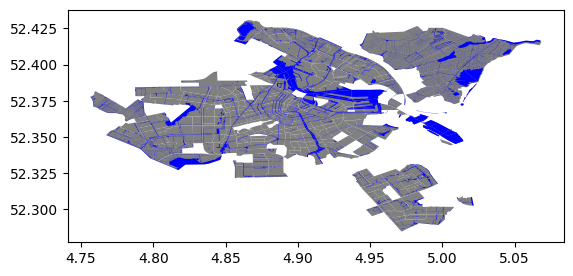

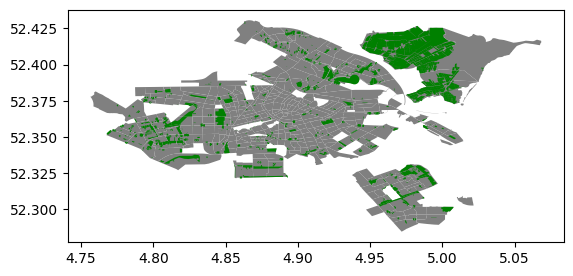

In [135]:
# Visualise the blue- and greenspace
# TODO: Make it look nice

fig, ax = plt.subplots(1,1)
gdf.set_geometry("geometry", inplace=True)
gdf.plot(ax=ax, color="grey")
gdf.set_geometry("blue_geometry", inplace=True)
gdf.plot(ax=ax, color="blue")
plt.show()

fig, ax = plt.subplots(1,1)
gdf.set_geometry("geometry", inplace=True)
gdf.plot(ax=ax, color="grey")
gdf.set_geometry("green_geometry", inplace=True)
gdf.plot(ax=ax, color="green")
plt.show()


In [136]:
# Transform coordinates to projection with accurate area 
gdf.set_geometry("geometry", inplace=True)
gdf.to_crs(crs_projected, inplace=True)
print(gdf.crs)
gdf.set_geometry("green_geometry", inplace=True)
gdf.to_crs(crs_projected, inplace=True)
print(gdf.crs)
gdf.set_geometry("blue_geometry", inplace=True)
gdf.to_crs(crs_projected, inplace=True)
print(gdf.crs)

print()

print(gdf.head(1)["geometry"])
print(gdf.head(1)["green_geometry"])
print(gdf.head(1)["blue_geometry"])


epsg:28992
epsg:28992
epsg:28992

4163    POLYGON ((4.901 52.377, 4.902 52.377, 4.902 52...
Name: geometry, dtype: geometry
4163    None
Name: green_geometry, dtype: geometry
4163    MULTIPOLYGON (((4.902 52.377, 4.902 52.377, 4....
Name: blue_geometry, dtype: geometry


In [137]:
# Use the geometries to calculate %green and %blue
def calc_blue(geo, blue_geo):
    if (blue_geo) is not None:
        return blue_geo.area / geo.area
    else:
        return 0

def calc_green(geo, green_geo):
    if (green_geo) is not None:
        return green_geo.area / geo.area
    else:
        return 0

gdf["percent_blue"] = gdf.apply(lambda row: calc_blue(row["geometry"], row["blue_geometry"]), axis = 1)
gdf["percent_green"] = gdf.apply(lambda row: calc_green(row["geometry"], row["green_geometry"]), axis = 1)
gdf.to_crs(crs_geographical, inplace=True)

In [138]:
# Set the geographies back into normal coordinates
gdf.set_geometry("geometry", inplace=True)
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)
gdf.set_geometry("green_geometry", inplace=True)
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)
gdf.set_geometry("blue_geometry", inplace=True)
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)

gdf.set_geometry("geometry", inplace=True)

epsg:4326
epsg:4326
epsg:4326


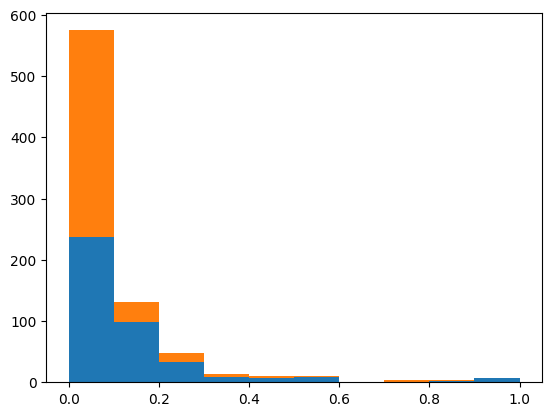

In [139]:
# Visualise the distibution of green- and bluespace
# TODO: Make this look nice
plt.hist(gdf[["percent_blue", "percent_green"]], stacked=True)
plt.show()

In [140]:
# Load Depression risk data fromm buurtatlas
# TODO: Get buurtatlas data for the other cities we want to use
path_buurtatlas = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/data/MATIG_HOOG_RISICO_ANGST_DEPRESSIE_BUURTEN.csv'
df_buurtatlas = pd.read_csv(path_buurtatlas, usecols=["GEBIED_NAAM", "18_en_ouder"])

# Delete the rows that are not neighborhoods
df_buurtatlas.drop([0,1,2], inplace=True)

# Impute missing values
# TODO: We could also drop the missing values instead
df_buurtatlas['18_en_ouder'].fillna((df_buurtatlas['18_en_ouder'].mean()), inplace=True)

# Rename belgieplein so both dataframes understand it
gdf.loc[gdf["BU_NAAM"] == "BelgiÃ«plein e.o.", "BU_NAAM"] = "Belgieplein"
df_buurtatlas.loc[df_buurtatlas["GEBIED_NAAM"] == "Belgiëplein e.o.", "GEBIED_NAAM"] = "Belgieplein"

df_buurtatlas.info()
df_buurtatlas.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 3 to 481
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEBIED_NAAM  479 non-null    object 
 1   18_en_ouder  479 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


,GEBIED_NAAM,18_en_ouder
3,Aalsmeerwegbuurt Oost,51.900000
4,Aalsmeerwegbuurt West,52.500000
5,Afrikahaven,51.812584
6,Alexanderplein e.o.,49.900000
7,Alfa-driehoek,51.812584


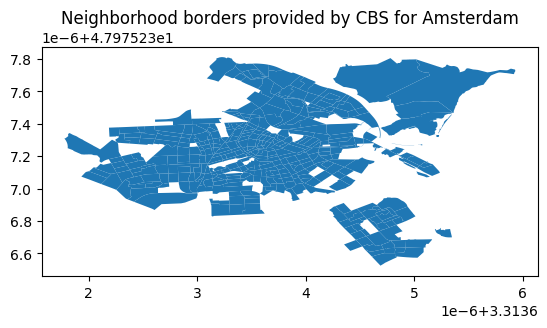

In [141]:
# Visualise the borders in Amsterdam to compare to buurtatlas
gdf.plot()

plt.title("Neighborhood borders provided by CBS for Amsterdam")
plt.show()


In [142]:
# Compare the names of BuurtAtlas and CBS 
names_cbs = gdf.sort_values("BU_NAAM")["BU_NAAM"].unique()
names_ba = df_buurtatlas.sort_values("GEBIED_NAAM")["GEBIED_NAAM"].unique()

for i in range(len(names_cbs)):
    if names_cbs[i] not in names_ba:
        print(f"{names_cbs[i]} is not found in the buurtatlas names")

for i in range(len(names_ba)):
    if names_ba[i] not in names_cbs:
        print(f"{names_ba[i]} is not found in the CBS names")

AMC is not found in the CBS names
Afrikahaven is not found in the CBS names
Alfa-driehoek is not found in the CBS names
Amerikahaven is not found in the CBS names
Amstel III deel A/B Noord is not found in the CBS names
Amstel III deel C/D Noord is not found in the CBS names
Amstel III deel C/D Zuid is not found in the CBS names
Amstelglorie is not found in the CBS names
Amstelkwartier Zuid is not found in the CBS names
Amstelpark is not found in the CBS names
Amsterdamse Bos is not found in the CBS names
Beatrixpark is not found in the CBS names
Bedrijvencentrum Osdorp is not found in the CBS names
Bedrijvencentrum Westerkwartier is not found in the CBS names
Bedrijvengebied Veelaan is not found in the CBS names
Bedrijvenpark Lutkemeer is not found in the CBS names
Bedrijventerrein Nieuwendammerdijk is not found in the CBS names
Bedrijventerrein Sloterdijk I is not found in the CBS names
Bretten Oost is not found in the CBS names
Bretten West is not found in the CBS names
Buiteneiland 

In [143]:
# Merge the two dataframes
df_buurtatlas.rename(columns={"GEBIED_NAAM": "BU_NAAM", "18_en_ouder": "DEPRESSION_RISK"}, inplace=True)
gdf = gdf.merge(df_buurtatlas, on="BU_NAAM", how="left")

# Split out the blue and green geometries
gdf_blue = gdf[["BU_CODE", "BU_NAAM", "GM_NAAM", "blue_geometry"]].copy()
gdf_blue.rename(columns={"blue_geometry": "geometry"},  inplace=True)
gdf_blue.info()

gdf_green = gdf[["BU_CODE", "BU_NAAM", "GM_NAAM", "green_geometry"]].copy()
gdf_green.rename(columns={"green_geometry": "geometry"},  inplace=True)
gdf_green.info()

# Drop the other geometries from the main gdf, or it will get confused
gdf.drop(["blue_geometry", "green_geometry"], axis=1, inplace=True)

gdf_blue.to_csv("data/blue_geometries.csv")
gdf_green.to_csv("data/green_geometries.csv")
gdf.to_csv("data/prepared_data.csv")

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   BU_CODE   403 non-null    object  
 1   BU_NAAM   403 non-null    object  
 2   GM_NAAM   403 non-null    object  
 3   geometry  375 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 15.7+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   BU_CODE   403 non-null    object  
 1   BU_NAAM   403 non-null    object  
 2   GM_NAAM   403 non-null    object  
 3   geometry  248 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 15.7+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           ------